# PINN result visualization

In [ ]:
from setproctitle import setproctitle
setproctitle("PINN (viz)")

In [ ]:
#| default_exp pinn_nf2_viz

In [ ]:
#| export
import os
import numpy as np
import pyvista as pv
from tqdm import tqdm

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [ ]:
#| export
import torch

In [ ]:
#| export
from cmspinn.mag_viz import create_physical_coordinates
from cmspinn.pinn_nf2_old import BModel

In [ ]:
#| export
class pinn_cube:
    def __init__(self, save_path):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.state = torch.load(save_path, map_location=self.device)
        self.model = self.state['model']
        self.cube_shape = self.state['cube_shape']
        self.b_norm = self.state['b_norm']
        self.spatial_norm = self.state['spatial_norm']
        
    def calculate_magnetic_fields(self, batch_size = 10000):
        device = self.device
        spatial_norm = self.spatial_norm
        b_norm = self.b_norm
        model = self.model
        
        Nx, Ny, Nz = self.cube_shape
        domain_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
        resolutions = (Nx, Ny, Nz)
        grid = create_physical_coordinates(domain_bounds, resolutions)
        domain_coords = np.array(grid.points)
        normalized_domain_coords = domain_coords / spatial_norm
        normalized_domain_coords = normalized_domain_coords
        normalized_domain_coords = torch.tensor(normalized_domain_coords, dtype=torch.float32)
        n_batch = int(np.ceil(normalized_domain_coords.shape[0] / batch_size))

        with torch.no_grad():
            cube = []
            for k in tqdm(range(n_batch)):
                batch_coords = normalized_domain_coords[k*batch_size : (k+1)*batch_size]
                # batch_coords.to(device)
                batch_coords = batch_coords.cuda()
                # model = model.to(batch_coords.device)
                model = model.cuda()
                cube += [model(batch_coords).detach().cpu()]
            cube = torch.cat(cube)
            B = cube.numpy()*b_norm
        
        Bx = B[:, 0]
        By = B[:, 1]
        Bz = B[:, 2]

        vectors = np.empty((grid.n_points, 3))
        vectors[:, 0] = Bx
        vectors[:, 1] = By
        vectors[:, 2] = Bz
        grid['B'] = vectors
        grid.active_vectors_name = 'B'
        magnitude = np.linalg.norm(vectors, axis=-1)
        grid['mag'] = magnitude
        grid.active_scalars_name = 'mag'

        self.grid = grid
        return self.grid

In [ ]:
save_path = '/userhome/jeon_mg/workspace/_data/NOAA12673/PINN/20170904_000000/model_010000.pt'

In [ ]:
pinn = pinn_cube(save_path)

In [ ]:
pinn.state

{'iteration': 10000,
 'model': DataParallel(
   (module): BModel(
     (d_in): Linear(in_features=3, out_features=256, bias=True)
     (linear_layers): ModuleList(
       (0): Linear(in_features=256, out_features=256, bias=True)
       (1): Linear(in_features=256, out_features=256, bias=True)
       (2): Linear(in_features=256, out_features=256, bias=True)
       (3): Linear(in_features=256, out_features=256, bias=True)
       (4): Linear(in_features=256, out_features=256, bias=True)
       (5): Linear(in_features=256, out_features=256, bias=True)
       (6): Linear(in_features=256, out_features=256, bias=True)
       (7): Linear(in_features=256, out_features=256, bias=True)
     )
     (d_out): Linear(in_features=256, out_features=3, bias=True)
     (activation): Sine()
   )
 ),
 'cube_shape': [344, 224, 160],
 'b_norm': 2500,
 'spatial_norm': 160,
 'loss_bc': array(0.003422, dtype=float32),
 'w_bc': 63.09573444803282,
 'loss_div': array(0.00469126, dtype=float32),
 'w_div': 1,
 'loss

In [ ]:
pinn.calculate_magnetic_fields(batch_size=10000)

100%|██████████| 1233/1233 [00:03<00:00, 329.67it/s]


ImageData (0x7f17f78cc3a0)
  N Cells:      12161751
  N Points:     12328960
  X Bounds:     0.000e+00, 3.430e+02
  Y Bounds:     0.000e+00, 2.230e+02
  Z Bounds:     0.000e+00, 1.590e+02
  Dimensions:   344, 224, 160
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

In [ ]:
pinn.grid

ImageData (0x7f17f78cc3a0)
  N Cells:      12161751
  N Points:     12328960
  X Bounds:     0.000e+00, 3.430e+02
  Y Bounds:     0.000e+00, 2.230e+02
  Z Bounds:     0.000e+00, 1.590e+02
  Dimensions:   344, 224, 160
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

In [ ]:
vtk_path = '/userhome/jeon_mg/workspace/_data/NOAA12673/PINN/20170904_000000/vtk' 
os.makedirs(vtk_path, exist_ok=True)

In [ ]:
B_pinn_vtk_path = os.path.join(vtk_path, 'B_pinn_10000.vtk')
pinn.grid.save(B_pinn_vtk_path)

In [ ]:
B_pinn_mesh = pv.read(B_pinn_vtk_path)

In [ ]:
from cmspinn.mag_viz import mag_plotter

In [ ]:
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend('static')

In [ ]:
B_pinn = mag_plotter(B_pinn_mesh)

In [ ]:
vmin = -3000
vmax = 3000

i_siz = 160
j_siz = 100

i_res = 15
j_res = 15

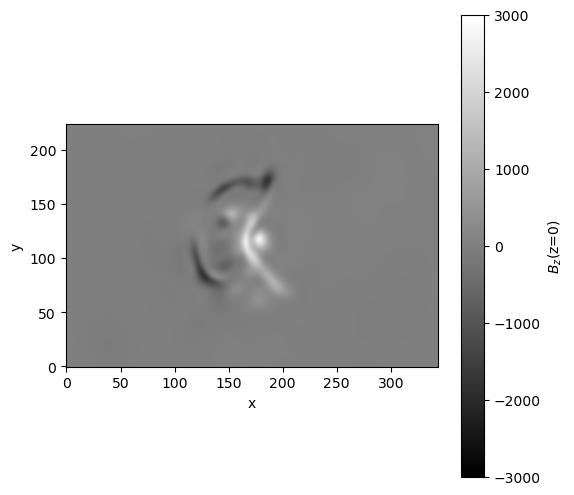

In [ ]:
B_pinn.plt_Bz_imshow(z=0, vmin=vmin, vmax=vmax)

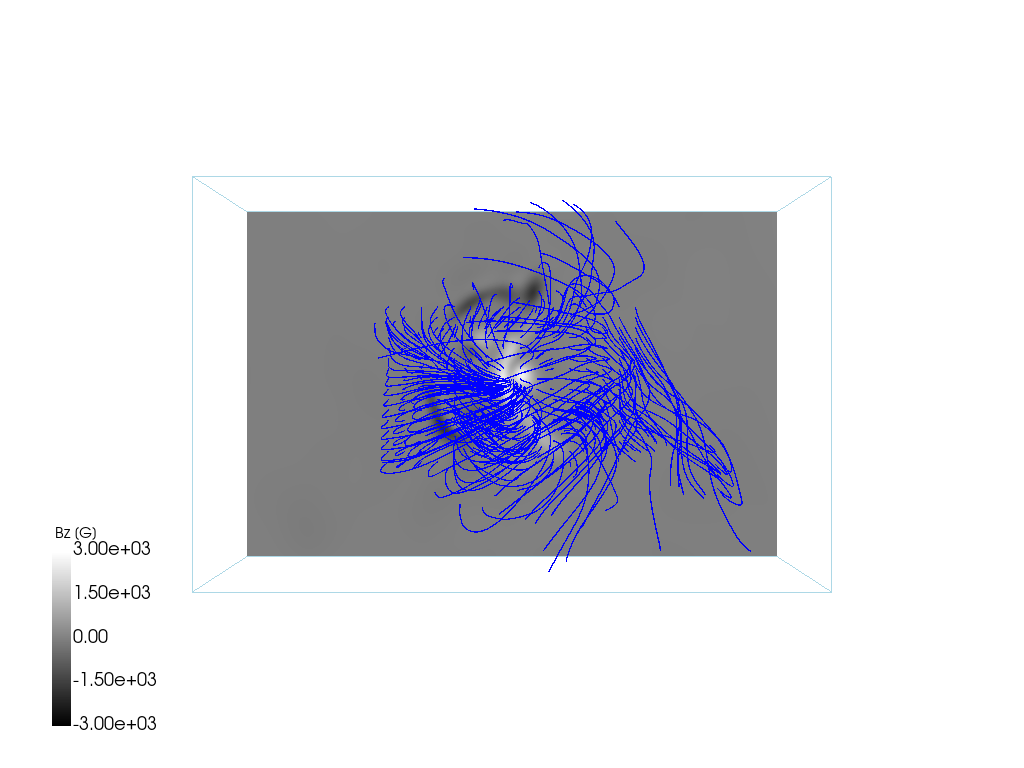

<pyvista.plotting.plotter.Plotter>

In [ ]:
B_pinn.pv_streamline_Bz(camera_position='xy', i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax)